## Streaming

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

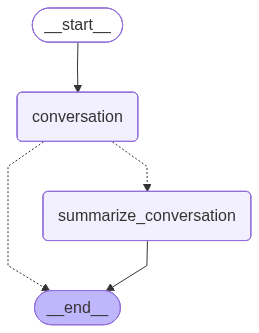

In [2]:
from IPython.display import Image, display
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-5-nano", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = InMemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable": {"thread_id": 1}}

for chunk in graph.stream({"messages": [HumanMessage(content = "hi! I'm Lance")]},
                          config = config,
                          stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Lance! Nice to meet you. How can I help today?  \nIf you’d like, tell me your goal or topic and I’ll tailor my help. For example:\n- Quick answers or explanations\n- Brainstorming ideas\n- Drafting emails, resumes, or code\n- Learning a new skill or planning a project\n- Travel planning or recommendations\n\nWhat would you like to dive into?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 475, 'prompt_tokens': 10, 'total_tokens': 485, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CwWtl1xHOuCU9aZ8axBHSVtWBhT91', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019ba8ea-d2ca-7cb0-a96e-3971

In [5]:
for chunk in graph.stream({"messages": [HumanMessage(content = "hi! I'm Lance")]},
                          config = config,
                          stream_mode="updates"):
    chunk['conversation']['messages'].pretty_print()

================================== Ai Message ==================================

Hi Lance! Nice to meet you. What would you like to work on today? I can help with quick answers, brainstorming, drafting (emails, resumes, code), learning a new skill, planning a project, or travel ideas. Tell me your goal and I’ll tailor my help.


In [ ]:
config = {"configurable": {"thread_id": 2}}

for chunk in graph.stream({"messages": [HumanMessage(content = "hi! I'm Shiv")]},
                          config = config,
                          stream_mode="values"):
    print(chunk)
    
    

{'messages': [HumanMessage(content="hi! I'm Shiv", additional_kwargs={}, response_metadata={}, id='6812ed3e-e1b7-416e-9c4f-5f6813c668f5')]}
{'messages': [HumanMessage(content="hi! I'm Shiv", additional_kwargs={}, response_metadata={}, id='6812ed3e-e1b7-416e-9c4f-5f6813c668f5'), AIMessage(content='Hi Shiv! Nice to meet you.\n\nWhat would you like to do today? I can help with explanations, writing and editing, coding, planning, brainstorming, or just a chat. If you tell me your goal, I’ll tailor my help.\n\nA few quick prompts you can try:\n- Explain [topic] in simple terms.\n- Draft an email about [subject].\n- Plan a [type of trip/event] for [duration].\n- Help me troubleshoot [coding problem or error].\n- Brainstorm ideas for [project or hobby].\n\nWhat are you up to right now?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 765, 'prompt_tokens': 10, 'total_tokens': 775, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audi

In [7]:
for chunk in graph.stream({"messages": [HumanMessage(content = "I want to write Shiv Mahapuran Katha story")]},
                          config = config,
                          stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content="hi! I'm Shiv", additional_kwargs={}, response_metadata={}, id='6812ed3e-e1b7-416e-9c4f-5f6813c668f5'), AIMessage(content='Hi Shiv! Nice to meet you.\n\nWhat would you like to do today? I can help with explanations, writing and editing, coding, planning, brainstorming, or just a chat. If you tell me your goal, I’ll tailor my help.\n\nA few quick prompts you can try:\n- Explain [topic] in simple terms.\n- Draft an email about [subject].\n- Plan a [type of trip/event] for [duration].\n- Help me troubleshoot [coding problem or error].\n- Brainstorm ideas for [project or hobby].\n\nWhat are you up to right now?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 765, 'prompt_tokens': 10, 'total_tokens': 775, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 640, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 

In [8]:
for chunk in graph.stream({"messages": [HumanMessage(content = "I want to write Shiv Mahapuran Katha story")]},
                          config = config,
                          stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='That’s a wonderful project, Shiv. I can help you plan, shape, and draft a Shiv Mahapuran Katha story in a voice that suits you. To tailor it well, a few quick choices from you would help. In the meantime, here are two solid structure options you can pick from, plus a ready-to-use sample opening to spark your voice.\n\nWhat I can offer\n- A chapter-by-chapter outline that fits Shiv Purana themes and episodes\n- A clear plot arc that stays devotional and engaging\n- Character roles and key episodes (Ganesh, Parvati, Shiva, Ganga, Neelkanth, Bhasmasura, etc.)\n- Voice options: devotional-traditional, mythic-narrative, or modern retelling with timeless themes\n- A starter sample in your chosen language and tone to begin writing\n\nTwo structure options (pick one)\nOption A: Traditional devotional narrative (10 chapters)\n1) Frame and invitation: A storyteller gathers listeners and invites them to ask, “Who is Shiva?” The purpose of the tale 

## Streaming tokens

In [9]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the Shiv Maha Puran")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019ba8f2-be90-7680-87f0-f0b980f6e38a', tool_calls=[], invalid_tool_calls=[], tool_call_chunks=[])}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019ba8f2-be90-7680-87f0-f0b980f6e38a', tool_calls=[], invalid_tool_calls=[], tool_call_chunks=[])}
{'chunk': AIMessageChunk(content=' Shiva', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019ba8f2-be90-7680-87f0-f0b980f6e38a', tool_calls=[], invalid_tool_calls=[], tool_call_chunks=[])}
{'chunk': AIMessageChunk(content=' Pur', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019ba8f2-be90-7680-87f0-f0b980f6e38a', tool_calls=[], invalid_tool_calls=[], tool_call_chunks=[])}
{'chunk': AIMessageChunk(content='ana', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='l

In [10]:
config = {"configurable": {"thread_id": 19}}
node_to_stream = "conversation"
input_message = HumanMessage(content = "Please tell me about the Shiv Maha Puran Katha")
async for event in graph.astream_events({"messages": [input_message]},
                                        config=config,
                                        version = "v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end = "|")

|Sh|iv| Mah|apur|ana| (|often| called| Shiva| Pur|ana|)| is| one| of| the| major| Hindu| texts| focused| on| Lord| Shiva|.| When| people| say| “|Sh|iv| Maha| P|uran| K|atha|,”| they| usually| mean| the| devotional| storytelling| (|k|atha|)| about| Shiva| that| comes| from| or| is| based| on| the| Shiva| Pur|ana|,| told| in| a| bh|akti| (|dev|otional|)| format|.

|What| it| is| in| brief|
|-| What| it| is|:| A| sacred| anthology| of| legends|,| cosm|ology|,| and| devotional| hym|ns| centered| on| Lord| Shiva|,| his| wife| Par|vati|,| their| children| G|anes|ha| and| Kart|ik|eya|,| and| Shiva|’s| many| forms| and| roles|.
|-| What| “|k|atha|”| means|:| A| storytelling| or| disc|ursive| presentation| (|prav|achan|)| of| Shiva|’s| gl|ories|,| often| given| by| a| trained| storyteller| (|k|ath|akar|)| at| temples|,| homes|,| or| temples| during| festivals| or| devotional| gatherings|.
|-| Auth|orship| and| dating|:| Traditionally| attributed| to| Vy|asa|,| but| like| many| P|uran|as| it| is

In [12]:
config = {"configurable": {"thread_id": 20}}
node_to_stream = "conversation"
input_message = HumanMessage(content = "Please tell me about the Shiv Maha Puran Katha")
async for event in graph.astream_events({"messages": [input_message]},
                                        config=config):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end = " ")

 Sh iv  Maha  P uran  K atha  usually  refers  to  the  stories  and  teaching  sections  of  the  Shiva  Pur ana  ( also  called  Shiva  Mah apur ana ).  It ’s  one  of  the  great  P uran as  in  Hindu ism  and  is  especially  central  to  Sha iv ism .  There  isn ’t  a  single  fixed  edition ,  because  the  Shiva  Pur ana  exists  in  several  rec ensions  and  manuscript  traditions ,  but  all  share  the  central  theme :  devotion  to  Lord  Shiva  and  the  philosophy ,  myths ,  and  rituals  associated  with  him .

 Key  points  about  Shiv  Maha  P uran  K atha 

 -  What  it  is 
    -  A  Sanskrit  scripture  focused  on  Lord  Shiva ,  his  wife  Par vati ,  their  sons  G anes ha  and  Kart ik eya ,  and  the  broader  Sha iva  worldview .
    -  It  blends  myth ,  theology ,  cosm ology ,  temple  lore ,  sacred  geography ,  and  guidance  on  worship  and  dh arma .

 -  What  kinds  of  stories  and  teachings  you ’ll  find 
    -  The  nature  and  forms  of  